In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def get_image(path, image_transform, size = (300,300)):
  image = Image.open(path)
  image = image.resize(size = size,resample = Image.LANCZOS)
  image = image_transform(image).unsqueeze(0) #Adds batch dimension
  return image.to(device)

In [10]:
def get_gram(image_matrix):
  """
  Uses the gram matrix to extract image similarities
  """

  _, channels, height, width = image_matrix.size()
  image_matrix = image_matrix.view(channels, height*width) #Flatten the image
  image_matrix = torch.mm(image_matrix,image_matrix.t()) #Product between image and its transpose
  return image_matrix

In [11]:
def denormalize_image(image):
  """ 
  Denormalizes image and transforms in numpy array
  Mean and Standard deviation values were taken from imagenet documentation

  """

  image = image.numpy().transpose((1,2,0)) #Pytorch uses (channels, height, width), numpy uses (height, width, channels)
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  image = image*std + mean
  image = np.clip(image,0,1)
  return image

In [18]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = models.vgg16(pretrained = True).features
    self.selected_layers = ['3','8','15','22'] #Layers after ReLU activation

  def forward(self,x):
    layer_features = []
    for layer_number, layer in self.vgg._modules.items():
      x = layer(x)
      if layer_number in self.selected_layers:
        layer_features.append(x)
    return layer_features


In [19]:
#mean and std from Imagenet
image_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(
                                      mean=(0.485,0.456,0.406), 
                                      std=(0.229,0.224,0.225))
                                      ])
path_original = '/content/original.jpg'
path_style = '/content/style.jpg'

original_image = get_image(path_original, image_transform)
style_image = get_image(path_style, image_transform)
generated_image = original_image.clone()
generated_image.requires_grad = True
optimizer = torch.optim.Adam([generated_image], lr = 0.003, betas= [0.5,0.999])
encoder = Model().to(device)

for parameter in encoder.parameters():
    parameter.requires_grad = False
#encoder.eval() #Freezes the parameters

In [ ]:
epochs = 3000
original_weight = 1
style_weight = 500

for epoch in range(epochs):
  original_features = encoder.forward(original_image)
  style_features = encoder.forward(style_image)
  generated_features = encoder.forward(generated_image)

  original_loss = torch.mean((original_features[-1] - generated_features[-1])**2) #MSE
  style_loss = 0

  for gen_features, stl_features in zip(generated_features, style_features):
    _, channels, height, width = gen_features.size()
    gram_gen_features = get_gram(gen_features)
    gram_stl_features = get_gram(stl_features)

    style_loss += torch.mean((gram_gen_features - gram_stl_features)**2)/(channels*height*width) #Normalized MSE

  loss = original_weight*original_loss + style_weight*style_loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch+1) %10 == 0:
    print(f'Epoch [{epoch+1}], Loss [Original/Style]: [{original_loss.item():.2f} / {style_loss.item():.2f}], Total loss: {loss.item():.2f}')

In [15]:
generated_image = generated_image.detach().cpu().squeeze()
generated_image = denormalize_image(generated_image)

(-0.5, 299.5, 299.5, -0.5)

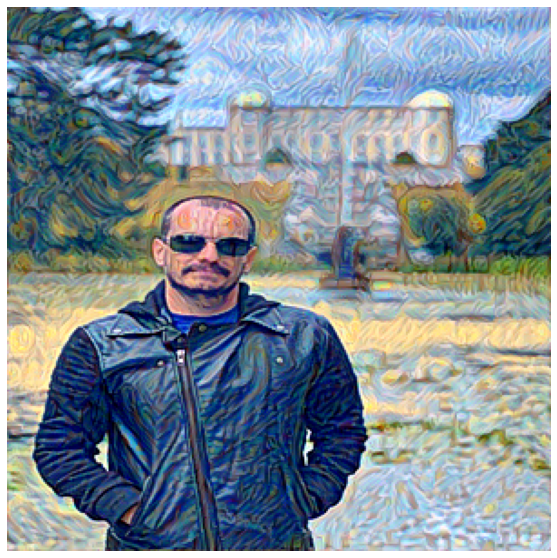

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(generated_image)
plt.axis('off')